# Using the CausalML package for uplift prediction on the Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset

## Introduction

The Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset contains 64,000 customers involved in an e-mail campaign.
The customers are randomly divided into three equal groups:

* the first group receives an e-mail campaign on Mens merchandise;
* the second group receives an e-mail campaign on Womens merchandise;
* the third group does not receive any campaign.

Since the customers receiving a treatment have the same probability of belonging to one of the three segments, the propensity score is known.

In this test we consider only one e-mail campaign at a time, therefore we exclude the individuals having received the other treatment.
This means that the propensity score of each customer is 0.5.

## Meta-Learners

In this first test, we use the Meta-Learners from the CausalML package. In particular, we use:

* S-Learner
* T-Learner
* X-Learner with propensity score
* R-Learner with propensity score


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier


from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner, BaseRLearner
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, auuc_score

import warnings
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline

In [3]:
from datasets import HillstromDataset

### Loading the data

We choose which campaign to analyze by changing the *campaign* parameter of *getCampaignData*. By choosing 1, we target
the Mens campaign, while by choosing 2 we target the Womens campaign.

We define the following vectors:
* y, the outcome
* X, the features
* w, the treatment indicator
* p, the propensity score

We split the data into a train set and a test set. In this test, the two sets have equal size.

In [4]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=1)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)


### CATE estimation

We initialize our Meta-Learners using a Random Forest model and we estimate the CATE. To do so, we train the model with the train set
and we predict the CATE on the test set.

In [5]:
# S Learner
learner_s = BaseSLearner(learner=RandomForestClassifier())
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTLearner(learner=RandomForestClassifier())
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner = RandomForestClassifier()
learner_x = BaseXLearner(learner=RandomForestClassifier())
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRLearner(learner=RandomForestClassifier())
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

### Uplift curve

We plot the uplift curve by using the dedicated function from the CausalML package. We estimate the area under the curve
to compare the different models.

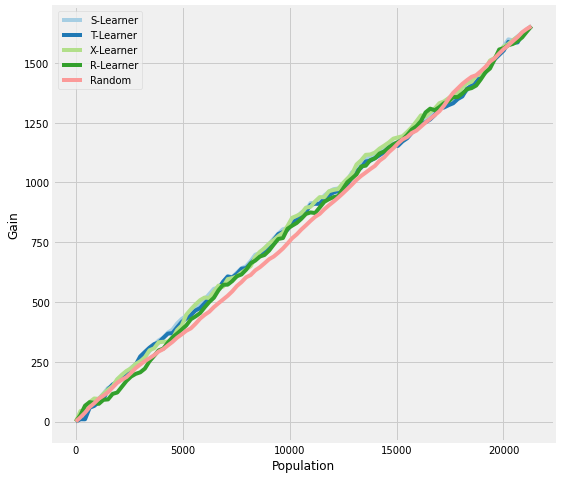

In [6]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'S-Learner': cate_s_test.flatten(),
                   'T-Learner': cate_t_test.flatten(), 'X-Learner': cate_x_test.flatten(), 'R-Learner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [7]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


S-Learner    0.513034
T-Learner    0.507820
X-Learner    0.515158
R-Learner    0.502192
Random       0.494188
dtype: float64

## Uplift Random Forest on Contextual Treatment Selection

In this test, we use the Uplift Tree from the CausalML package. As a splitting criterion, we choose CTS (Contextual Treatment Selection).

In [8]:
uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
y_pred = uplift_model.predict(X=X_test)

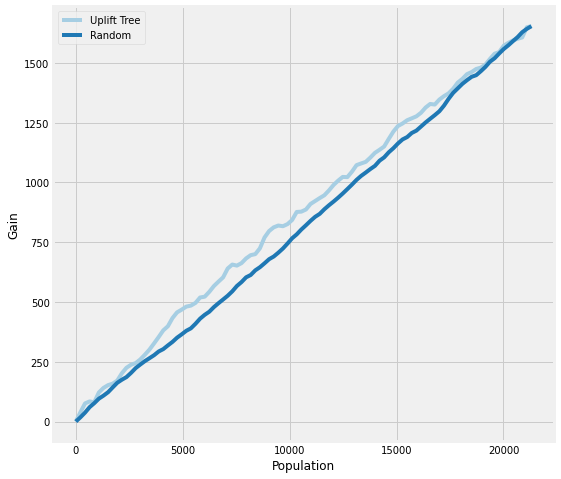

In [9]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Tree': y_pred.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [10]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


Uplift Tree    0.527177
Random         0.494188
dtype: float64

## Comparison between the two campaigns

For comparison, we repeat here the same steps by chosing the Womens campaign.

In [11]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=2)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)


### Meta-Learners with Random Forest

In [12]:
# S Learner
learner_s = BaseSLearner(learner=RandomForestClassifier())
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTLearner(learner=RandomForestClassifier())
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXLearner(learner=RandomForestClassifier())
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRLearner(learner=RandomForestClassifier())
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

Uplift curves for Meta-Learners with Random Forest

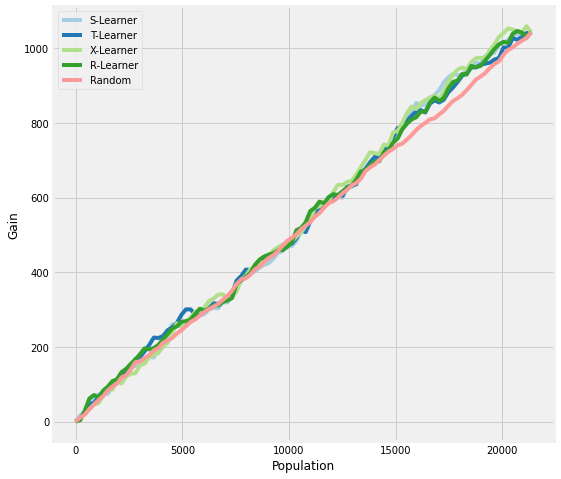

In [13]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'S-Learner': cate_s_test.flatten(),
                   'T-Learner': cate_t_test.flatten(), 'X-Learner': cate_x_test.flatten(), 'R-Learner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [14]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


S-Learner    0.515046
T-Learner    0.515511
X-Learner    0.520043
R-Learner    0.516502
Random       0.500102
dtype: float64

### Uplift Random Forest on Contextual Treatment Selection

In [15]:
uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
y_pred = uplift_model.predict(X=X_test)

Uplift curves for Uplift Random Forest with Contextual Treatment Selection

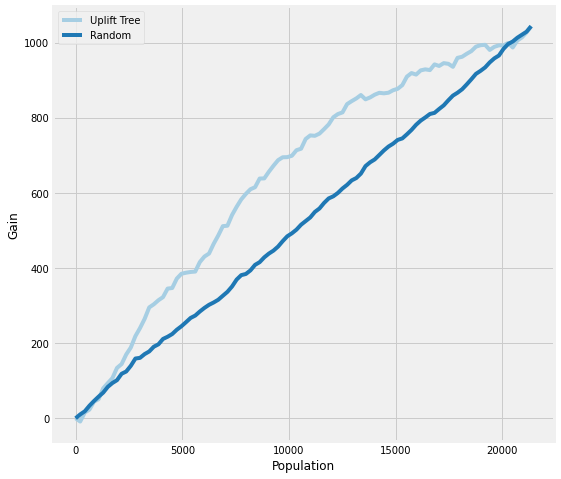

In [16]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Tree': y_pred.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [17]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


Uplift Tree    0.619345
Random         0.500102
dtype: float64